In [ ]:
import warnings
# Ignore numpy dtype warnings. These warnings are caused by an interaction
# between numpy and Cython and can be safely ignored.
# Reference: https://stackoverflow.com/a/40846742
warnings.filterwarnings("ignore", message="numpy.dtype size changed")
warnings.filterwarnings("ignore", message="numpy.ufunc size changed")

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
%matplotlib inline
import ipywidgets as widgets
from ipywidgets import interact, interactive, fixed, interact_manual
import nbinteract as nbi

sns.set()
sns.set_context('talk')
np.set_printoptions(threshold=20, precision=2, suppress=True)
pd.options.display.max_rows = 7
pd.options.display.max_columns = 8
pd.set_option('precision', 2)
# This option stops scientific notation for pandas
# pd.set_option('display.float_format', '{:.2f}'.format)

In [95]:
def df_interact(df, nrows=7, ncols=7):
    '''
    Outputs sliders that show rows and columns of df
    '''
    def peek(row=0, col=0):
        return df.iloc[row:row + nrows, col:col + ncols]
    if len(df.columns) <= ncols:
        interact(peek, row=(0, len(df) - nrows, nrows), col=fixed(0))
    else:
        interact(peek,
                 row=(0, len(df) - nrows, nrows),
                 col=(0, len(df.columns) - ncols))
    print('({} rows, {} columns) total'.format(df.shape[0], df.shape[1]))

In [177]:
df = pd.read_csv('water_large.csv')

In [195]:
from collections import namedtuple
Curve = namedtuple('Curve', ['xs', 'ys'])

def flatten(seq): return [item for subseq in seq for item in subseq]

def make_curve(clf, x_start=-50, x_end=50):
    xs = np.linspace(x_start, x_end, num=100)
    ys = clf.predict(xs.reshape(-1, 1))
    return Curve(xs, ys)

def plot_data(df=df, ax=plt, **kwargs):
    ax.scatter(df.iloc[:, 0], df.iloc[:, 1], s=50, **kwargs)

def plot_curve(curve, ax=plt, **kwargs):
    ax.plot(curve.xs, curve.ys, **kwargs)
    
def plot_curves(curves, cols=2):
    rows = int(np.ceil(len(curves) / cols))
    fig, axes = plt.subplots(rows, cols, figsize=(10, 8),
                             sharex=True, sharey=True)
    for ax, curve, deg in zip(flatten(axes), curves, degrees):
        plot_data(ax=ax, label='Training data')
        plot_curve(curve, ax=ax, label=f'Deg {deg} poly')
        ax.set_ylim(-5e10, 170e10)
        ax.legend()
        
    # add a big axes, hide frame
    fig.add_subplot(111, frameon=False)
    # hide tick and tick label of the big axes
    plt.tick_params(labelcolor='none', top='off', bottom='off',
                    left='off', right='off')
    plt.grid(False)
    plt.title('Polynomial Regression')
    plt.xlabel('Water Level Change (m)')
    plt.ylabel('Water Flow (Liters)')
    plt.tight_layout()
    
def print_coef(clf):
    reg = clf.named_steps['reg']
    print(reg.intercept_)
    print(reg.coef_)

In [209]:
X = df.iloc[:, [0]].as_matrix()
y = df.iloc[:, 1].as_matrix()

degrees = [1, 2, 8, 12]
clfs = [Pipeline([('poly', PolynomialFeatures(degree=deg, include_bias=False)),
                  ('reg', LinearRegression())])
        .fit(X, y)
        for deg in degrees]

curves = [make_curve(clf) for clf in clfs]

ridge_clfs = [Pipeline([('poly', PolynomialFeatures(degree=deg, include_bias=False)),
                        ('reg', Ridge(alpha=0.1, normalize=True))])
        .fit(X, y)
        for deg in degrees]

ridge_curves = [make_curve(clf) for clf in ridge_clfs]

# Regularization Intuition

We begin our discussion of regularization with an example that illustrates the importance of regularization.

## Dam Data

The following dataset records the amount of water that flows out of a large dam on a particular day in liters and the amount the water level changed on that day in meters.

In [185]:
df

,water_level_change,water_flow
0,-15.936758,6.042233e+10
1,-29.152979,3.321490e+10
2,36.189549,9.727064e+11
...,...,...
20,7.085480,2.363520e+11
21,46.282369,1.494256e+12
22,14.612289,3.781463e+11


Plotting this data shows an upward trend in water flow as the water level becomes more positive.

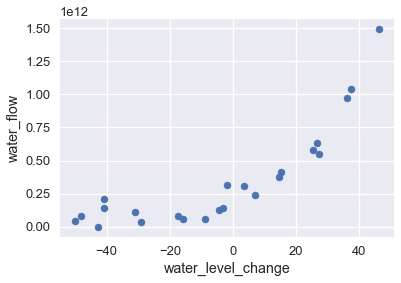

In [186]:
df.plot.scatter(0, 1, s=50);

To model this pattern, we may use a least squares linear regression model. We show the data and the model's predictions on the plot below.

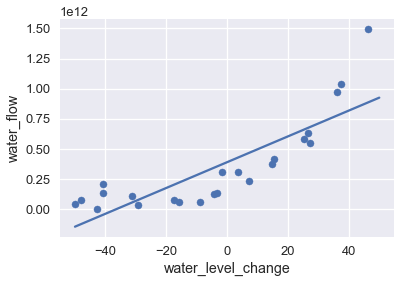

In [187]:
df.plot.scatter(0, 1, s=50);
plot_curve(curves[0])

The visualization shows that this model does not capture the pattern in the data—the model has high bias. As we have previously done, we can attempt to address this issue by adding polynomial features to the data. We add polynomial features of degrees 2, 8, and 12; the chart below shows the training data with each model's predictions.

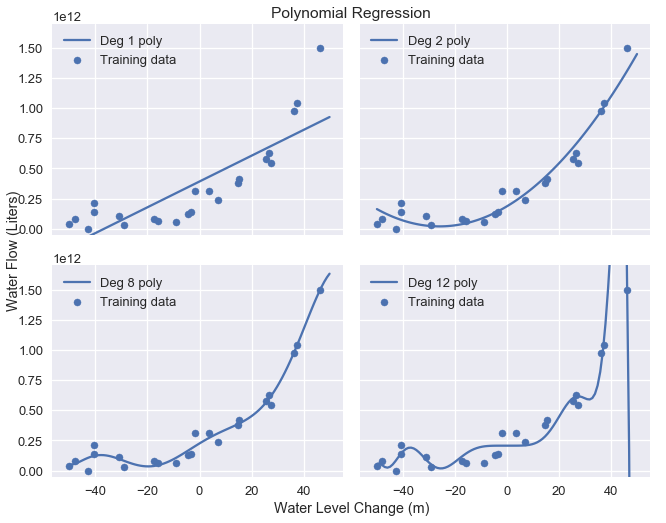

In [188]:
plot_curves(curves)

As expected, the degree 12 polynomial matches the training data well but also seems to fit spurious patterns in the data caused by noise. This provides yet another illustration of the bias-variance tradeoff: the linear model has high bias and low variance while the degree 12 polynomial has low bias but high variance.

## Examining Coefficients

Examining the coefficients of the degree 12 polynomial model reveals that this model makes predictions according to the following formula:

$$
207097470825 + 1.8x + 482.6x^2 + 601.5x^3 + 872.8x^4 + 150486.6x^5 \\
    + 2156.7x^6 - 307.2x^7 - 4.6x^8 + 0.2x^9 + 0.003x^{10} - 0.00005x^{11} + 0x^{12}
$$

where $ x $ is the water level change on that day.

The coefficients for the model are quite large, especially for the higher degree terms which contribute significantly to the model's variance ($ x^5 $ and $ x^6 $, for example).

## Penalizing Parameters

Recall that our linear model makes predictions according to the following, where $ \theta $ is the model weights and $ x $ is the vector of features:

$$
f_\hat{\theta}(x) = \hat{\theta} \cdot x
$$

To fit our model, we minimize the mean squared error cost function, where $ X $ is used to represent the data matrix and $ y $ the observed outcomes:

$$
\begin{aligned}
L(\hat{\theta}, X, y)
&= \frac{1}{n} \sum_{i}(y_i - f_\hat{\theta} (X_i))^2\\
\end{aligned}
$$

To minimize the cost above, we adjust $ \hat{\theta} $ until we find the best combination of weights regardless of how large the weights are themselves. However, we have found that larger weights for more complex features result in high model variance. If we could instead alter the cost function to penalize large weight values, the resulting model will have lower variance. We use regularization to add this penalty.